In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:

def load_image(image_path, target_size=(256, 256)):
    """Load and preprocess the image."""
    image = Image.open(image_path)
    image = image.resize(target_size)  # Resize to consistent size
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Set the dataset folder path
dataset_folder = './lol_dataset/'

# Define folder paths
eval15_low_folder = os.path.join(dataset_folder, 'eval15', 'low')
eval15_high_folder = os.path.join(dataset_folder, 'eval15', 'high')
our485_low_folder = os.path.join(dataset_folder, 'our485', 'low')
our485_high_folder = os.path.join(dataset_folder, 'our485', 'high')

# Get the list of images
eval15_low_images = [os.path.join(eval15_low_folder, img) for img in os.listdir(eval15_low_folder)]
eval15_high_images = [os.path.join(eval15_high_folder, img) for img in os.listdir(eval15_high_folder)]
our485_low_images = [os.path.join(our485_low_folder, img) for img in os.listdir(our485_low_folder)]
our485_high_images = [os.path.join(our485_high_folder, img) for img in os.listdir(our485_high_folder)]

# Load images into arrays
eval15_low_data = [load_image(img_path) for img_path in eval15_low_images]
eval15_high_data = [load_image(img_path) for img_path in eval15_high_images]
our485_low_data = [load_image(img_path) for img_path in our485_low_images]
our485_high_data = [load_image(img_path) for img_path in our485_high_images]

# Combine data from both datasets
X_data = eval15_low_data + our485_low_data
y_data = eval15_high_data + our485_high_data

# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Low-light data shape: {X_data.shape}")
print(f"High-light data shape: {y_data.shape}")


Low-light data shape: (500, 256, 256, 3)
High-light data shape: (500, 256, 256, 3)


In [4]:
# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (400, 256, 256, 3)
Validation data shape: (100, 256, 256, 3)


In [5]:
def build_model(input_shape):
    """Build a simple CNN model for low-light image enhancement."""
    model = models.Sequential()
    
    # Encoder part: Convolutional layers to extract features
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Decoder part: Upsampling to reconstruct the image
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    # Output layer
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # RGB output
    
    return model

# Build the model
input_shape = (256, 256, 3)
model = build_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,755 (1.14 MB)

 Trainable params: 298,755 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Save the trained model
model.save('low_light_image_enhanced_model.h5')


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0425 - val_loss: 0.0322
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0320 - val_loss: 0.0260
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0279 - val_loss: 0.0223
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0280 - val_loss: 0.0238
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0259 - val_loss: 0.0227
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0236 - val_loss: 0.0236
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0256 - val_loss: 0.0235
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0270 - val_loss: 0.0227
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0262 - val_loss: 0.0226
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0238 - val_loss: 0.0219


In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Assuming y_val and y_pred are your validation ground truth and predicted images
for i in range(5):
    psnr_value = psnr(y_val[i], y_pred[i])
    
    # Specify data_range based on your image value range
    ssim_value = ssim(y_val[i], y_pred[i], multichannel=True, win_size=3, channel_axis=2, data_range=1)  # or data_range=255
    
    print(f"Image {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")


Image 1 - PSNR: 18.09, SSIM: 0.7238
Image 2 - PSNR: 18.48, SSIM: 0.7091
Image 3 - PSNR: 19.83, SSIM: 0.6869
Image 4 - PSNR: 16.13, SSIM: 0.5903
Image 5 - PSNR: 14.90, SSIM: 0.7069


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


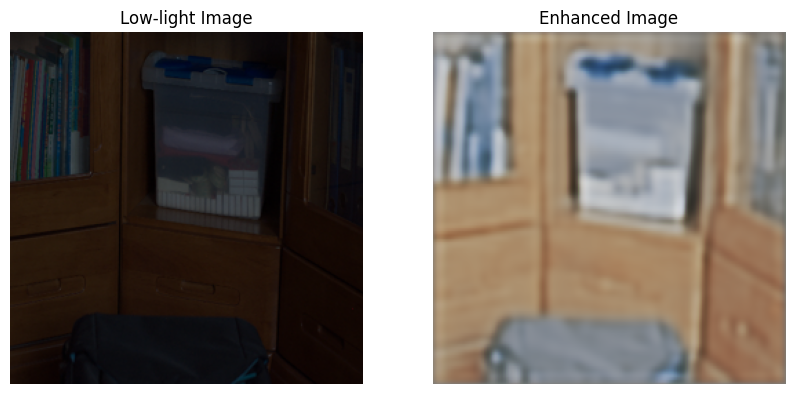

In [13]:
# Load a new low-light image for enhancement
sample_low_light_image = X_val[1]  # Use the first image from validation set for example

# Add batch dimension (model expects a batch)
sample_low_light_image_batch = np.expand_dims(sample_low_light_image, axis=0)

# Enhance the image
enhanced_image = model.predict(sample_low_light_image_batch)[0]

# Display the enhanced image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Original low-light image
plt.subplot(1, 2, 1)
plt.imshow(sample_low_light_image)
plt.title("Low-light Image")
plt.axis('off')

# Enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enhanced Image")
plt.axis('off')

plt.show()
